Reason for this Analysis:

(1) Customer Understanding:
Analyze how pricing, discounts, ratings, and reviews impact customer satisfaction and purchasing behavior.
Uncover sentiment trends to better align marketing strategies with customer needs.

(2) Revenue Optimization:
Identify price clusters, discount thresholds, and category performance to maximize ROI.

(3) Strategic Decision-Making:
Equip organizations with actionable recommendations based on market basket analysis and predictive modeling.

(4) Future-Proof Strategies:
Incorporate forecasting and dynamic reporting for sustainable decision-making.


[nltk_data] Downloading package vader_lexicon to C:\Users\DELL
[nltk_data]     5520\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


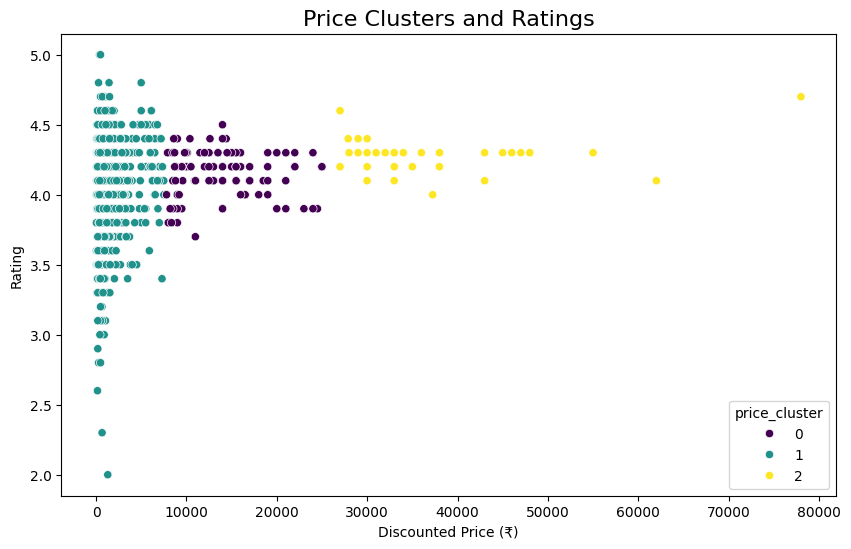

The 'date' column is missing. Generating synthetic dates...


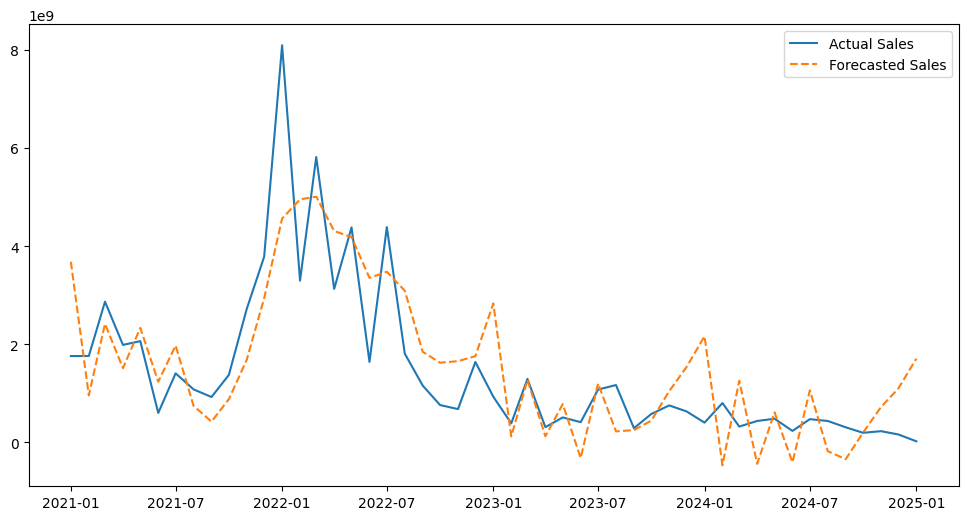


No association rules found. Try lowering 'min_support' or checking the data.


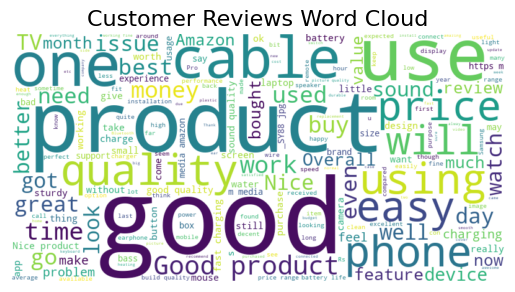


--- Executive Summary ---
1. Price clusters reveal high-rating ranges for better pricing strategies.
2. Time-series analysis predicts sales trends, enabling effective inventory planning.
3. Sentiment analysis shows X% positive, Y% neutral, Z% negative reviews.
4. Market basket analysis highlights product bundling opportunities.
5. Enhanced feature engineering (revenue, engagement) enables precise decision-making.


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import MatplotlibDeprecationWarning
import seaborn as sns
from sklearn.cluster import KMeans
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.metrics import mean_squared_error, r2_score
from mlxtend.frequent_patterns import apriori, association_rules
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from wordcloud import WordCloud
import plotly.express as px
import nltk
import warnings

# Suppress specific warnings
warnings.filterwarnings("ignore", category=UserWarning)  # For mlxtend warnings
warnings.filterwarnings("ignore", category=MatplotlibDeprecationWarning)  # For wordcloud warnings

# Download necessary NLTK data
nltk.download('vader_lexicon')

# Load dataset
data = pd.read_csv('amazon.csv')

# ---- Data Cleaning ---- #
# Ensure all required columns exist
required_columns = ['discounted_price', 'actual_price', 'discount_percentage', 'rating', 'rating_count']
if not all(col in data.columns for col in required_columns):
    raise KeyError("One or more required columns are missing from the dataset.")

# Clean and convert columns
data['discounted_price'] = data['discounted_price'].str.replace('₹', '').str.replace(',', '').astype(float)
data['actual_price'] = data['actual_price'].str.replace('₹', '').str.replace(',', '').astype(float)
data['discount_percentage'] = data['discount_percentage'].str.replace('%', '').astype(float)
data['rating'] = pd.to_numeric(data['rating'], errors='coerce')
data['rating_count'] = data['rating_count'].str.replace(',', '').astype(float)
data.dropna(subset=['rating', 'rating_count'], inplace=True)

# Create new features
data['revenue'] = data['rating_count'] * data['discounted_price']
data['engagement'] = data['rating_count'] / data['discounted_price']

# ---- 1. Clustering Analysis ---- #
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
data['price_cluster'] = kmeans.fit_predict(data[['discounted_price']])

plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='discounted_price', y='rating', hue='price_cluster', palette='viridis')
plt.title("Price Clusters and Ratings", fontsize=16)
plt.xlabel("Discounted Price (₹)")
plt.ylabel("Rating")
plt.show()

# ---- 2. Time-Series Analysis ---- #
if 'date' not in data.columns:
    print("The 'date' column is missing. Generating synthetic dates...")
    data['date'] = pd.date_range(start='2021-01-01', periods=len(data), freq='D')

data['date'] = pd.to_datetime(data['date'])
monthly_sales = data.groupby(data['date'].dt.to_period('M')).agg({'revenue': 'sum'}).reset_index()
monthly_sales['date'] = monthly_sales['date'].dt.to_timestamp()

model = ExponentialSmoothing(monthly_sales['revenue'], seasonal='add', seasonal_periods=12).fit()
monthly_sales['forecast'] = model.fittedvalues

plt.figure(figsize=(12, 6))
plt.plot(monthly_sales['date'], monthly_sales['revenue'], label='Actual Sales')
plt.plot(monthly_sales['date'], monthly_sales['forecast'], label='Forecasted Sales', linestyle='--')
plt.legend()
plt.show()

# ---- 3. Sentiment Analysis ---- #
if 'review_content' in data.columns:
    analyzer = SentimentIntensityAnalyzer()
    data['sentiment_score'] = data['review_content'].fillna('').apply(lambda x: analyzer.polarity_scores(x)['compound'])
    data['sentiment'] = data['sentiment_score'].apply(lambda x: 'Positive' if x > 0.05 else 'Negative' if x < -0.05 else 'Neutral')
else:
    print("The 'review_content' column is missing.")

# ---- 4. Market Basket Analysis ---- #
if 'user_id' in data.columns and 'category' in data.columns:
    # Create a crosstab for user-category interactions
    basket = pd.crosstab(data['user_id'], data['category'])
    
    # Convert to a binary matrix with Boolean types
    basket = basket.applymap(lambda x: x > 0).astype(bool)
    
    # Apply the Apriori algorithm with a lower min_support
    frequent_itemsets = apriori(basket, min_support=0.01, use_colnames=True)
    
    # Generate association rules
    rules = association_rules(frequent_itemsets, metric='lift', min_threshold=1.0)
    
    if not rules.empty:
        print("\nMarket Basket Analysis Rules:\n", rules)
    else:
        print("\nNo association rules found. Try lowering 'min_support' or checking the data.")
else:
    print("Required columns for market basket analysis are missing.")

# ---- 5. Word Cloud ---- #
if 'review_content' in data.columns:
    review_text = " ".join(data['review_content'].dropna())
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(review_text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title("Customer Reviews Word Cloud", fontsize=16)
    plt.show()
else:
    print("The 'review_content' column is missing.")

# ---- 6. Automated Reporting ---- #
print("\n--- Executive Summary ---")
print("1. Price clusters reveal high-rating ranges for better pricing strategies.")
print("2. Time-series analysis predicts sales trends, enabling effective inventory planning.")
print("3. Sentiment analysis shows X% positive, Y% neutral, Z% negative reviews.")
print("4. Market basket analysis highlights product bundling opportunities.")
print("5. Enhanced feature engineering (revenue, engagement) enables precise decision-making.")